# Residual Networks

Chào mừng đến với nhiệm vụ thứ hai của tuần này! Bạn sẽ học cách xây dựng các mạng phức hợp rất sâu, sử dụng Mạng dư (ResNets). Về lý thuyết, các mạng rất sâu có thể biểu diễn các chức năng rất phức tạp; nhưng trong thực tế, họ khó đào tạo. Mạng dư, được giới thiệu bởi [He et al.](Https://arxiv.org/pdf/1512.03385.pdf), cho phép bạn đào tạo các mạng sâu hơn nhiều so với khả năng thực tế trước đây.



## <font color = 'darkblue'> Cập nhật </font>

#### Nếu bạn đang làm việc trên sổ ghi chép trước bản cập nhật này ...
* Máy tính xách tay hiện tại là phiên bản "2a".
* Bạn có thể tìm thấy tác phẩm gốc của mình được lưu trong sổ ghi chép với tên phiên bản trước đó ("v2")
* Để xem thư mục tệp, hãy chuyển đến menu "Tệp-> Mở", và thao tác này sẽ mở ra một tab mới hiển thị thư mục tệp.

#### Danh sách cập nhật
* Để thử nghiệm trên hình ảnh, hãy thay thế `preprocess_input (x)` bằng `x = x / 255.0` để chuẩn hóa hình ảnh đầu vào giống như cách chuẩn hóa dữ liệu huấn luyện của mô hình.
* Đề cập đến các lớp "nông hơn" khi các lớp đó gần đầu vào hơn và các lớp "sâu hơn" khi các lớp gần đầu ra hơn (Sử dụng các lớp "nông hơn" thay vì "thấp hơn" hoặc "sớm hơn").
* Đã thêm / cập nhật hướng dẫn.

Nhiệm vụ này sẽ được thực hiện ở Keras.

Trước khi giải quyết vấn đề, hãy chạy ô bên dưới để tải các gói cần thiết.

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

from test_utils import summary, comparator
import public_tests

%matplotlib inline

## 1 - The problem of very deep neural networks
Tuần trước, bạn đã xây dựng mạng nơ-ron phức hợp đầu tiên của mình. Trong những năm gần đây, mạng nơ-ron đã trở nên sâu rộng hơn, với các mạng hiện đại chỉ từ một vài lớp (ví dụ: AlexNet) đến hơn một trăm lớp.

* Lợi ích chính của một mạng rất sâu là nó có thể biểu diễn các chức năng rất phức tạp. Nó cũng có thể tìm hiểu các tính năng ở nhiều mức độ trừu tượng khác nhau, từ các cạnh (ở các lớp nông hơn, gần đầu vào hơn) đến các tính năng rất phức tạp (ở các lớp sâu hơn, gần đầu ra hơn).
* Tuy nhiên, việc sử dụng mạng sâu hơn không phải lúc nào cũng hữu ích. Một rào cản lớn đối với việc đào tạo chúng là độ dốc biến mất: các mạng rất sâu thường có tín hiệu chuyển màu nhanh chóng về 0, do đó làm cho độ dốc xuống thấp nghiêm trọng.
* Cụ thể hơn, trong quá trình giảm dần độ dốc, khi bạn lùi từ lớp cuối cùng trở lại lớp đầu tiên, bạn đang nhân với ma trận trọng số trên mỗi bước và do đó, độ dốc có thể giảm theo cấp số nhân nhanh chóng đến 0 (hoặc, trong một số trường hợp hiếm hoi, tăng nhanh chóng theo cấp số nhân và "bùng nổ" để nhận các giá trị rất lớn).
* Do đó, trong quá trình đào tạo, bạn có thể thấy độ lớn (hoặc định mức) của gradient cho các lớp nông hơn giảm xuống 0 rất nhanh khi quá trình đào tạo diễn ra:

![](https://drive.google.com/uc?export=view&id=1t3Ksj1qyOH9YUetCx30PflWvFmyNiEJy)**Figure 1** </u><font color='purple'>  :
**Độ dốc biến mất** <br> Tốc độ học tập giảm rất nhanh đối với các lớp nông hơn khi mạng đào tạo </center> </caption>

Bây giờ bạn sẽ giải quyết vấn đề này bằng cách xây dựng một mạng dư!

## 2 - Building a Residual Network
Trong ResNets, "phím tắt" hoặc "bỏ qua kết nối" cho phép mô hình bỏ qua các lớp:
![](https://drive.google.com/uc?export=view&id=1Lxutof_6LaqKPoNrjpSVN4UFlKO6as-Z)
**Figure 2** </u><font color='purple'>  : A ResNet block showing a **skip-connection** <br> </center></caption>

Skip connection "skips over" 2 layers. </center></caption>
Hình ảnh bên trái cho thấy "đường dẫn chính" thông qua mạng. Hình ảnh bên phải thêm một lối tắt đến đường dẫn chính. Bằng cách xếp chồng các khối ResNet này lên nhau, bạn có thể tạo thành một mạng rất sâu.

Chúng tôi cũng đã thấy trong bài giảng rằng việc có các khối ResNet với phím tắt cũng giúp một trong các khối rất dễ học một hàm nhận dạng. Điều này có nghĩa là bạn có thể xếp chồng lên các khối ResNet bổ sung mà ít có nguy cơ ảnh hưởng đến hiệu suất tập huấn luyện.
    
(Cũng có một số bằng chứng cho thấy việc dễ dàng học một hàm nhận dạng mang lại hiệu suất đáng kể của ResNets thậm chí còn hơn cả việc bỏ qua các kết nối giúp làm biến mất các gradient).

Hai loại khối chính được sử dụng trong ResNet, phụ thuộc chủ yếu vào việc kích thước đầu vào / đầu ra giống nhau hay khác nhau. Bạn sẽ triển khai cả hai: " "identity block"" và "convolutional block".

### 2.1 - The identity block
Khối nhận dạng là khối tiêu chuẩn được sử dụng trong ResNets và tương ứng với trường hợp kích hoạt đầu vào (giả sử $ a ^ {[l]} $) có cùng thứ nguyên với kích hoạt đầu ra (giả sử $ a ^ {[l + 2 ]} $). Để xác định các bước khác nhau của những gì xảy ra trong khối nhận dạng của ResNet, đây là một sơ đồ thay thế hiển thị các bước riêng lẻ:
![](https://drive.google.com/uc?export=view&id=1QeSYnm_ZAs-Mlb7oNmu2EBK0s_Oq9idr)
<caption><center> <u> <font color='purple'>Figure 3 </u><font color='purple'>  : Identity block. Skip connection "skips over" 2 layers. </center></caption>

Đường dẫn phía trên là "đường tắt." Đường dẫn thấp hơn là "đường dẫn chính". Trong sơ đồ này, chúng tôi cũng đã trình bày rõ ràng các bước CONV2D và ReLU trong mỗi lớp. Để tăng tốc quá trình đào tạo, chúng tôi cũng đã thêm bước BatchNorm. Đừng lo lắng về việc triển khai này phức tạp - bạn sẽ thấy rằng BatchNorm chỉ là một dòng mã trong Keras!

Trong bài tập này, bạn sẽ thực sự triển khai một phiên bản mạnh hơn một chút của khối nhận dạng này, trong đó kết nối bỏ qua "bỏ qua" 3 lớp ẩn thay vì 2 lớp. Nó trông như thế này:
![](https://drive.google.com/uc?export=view&id=1gLpyKR1gJw4h8-8jfuipacKe2xfELJRP)
<caption><center> <u> <font color='purple'>Figure 4</u><font color='purple'>  : Identity block.Skip connection "skips over" 3 layers.</center></caption>

Đây là các bước riêng lẻ:

Thành phần đầu tiên của đường dẫn chính:
- CONV2D đầu tiên có $ F_1 $ bộ lọc có hình dạng (1,1) và sải chân là (1,1). Phần đệm của nó là "valid". Sử dụng 0 làm hạt giống cho khởi tạo thống nhất ngẫu nhiên: `kernel_initializer = initializer(seed=0)`.
- BatchNorm đầu tiên đang chuẩn hóa trục 'kênh'.
- Sau đó áp dụng chức năng kích hoạt ReLU. Điều này không có siêu tham số.

Thành phần thứ hai của đường dẫn chính:
- CONV2D thứ hai có $ F_2 $ bộ lọc của hình $ (f, f) $ và sải chân là (1,1). Phần đệm của nó là "same". Sử dụng 0 làm hạt giống cho khởi tạo thống nhất ngẫu nhiên: `kernel_initializer = initializer(seed=0)`.
- BatchNorm thứ hai đang chuẩn hóa trục 'kênh'.
- Sau đó áp dụng chức năng kích hoạt ReLU. Điều này không có siêu tham số.

Thành phần thứ ba của đường dẫn chính:
- CONV2D thứ ba có bộ lọc $ F_3 $ có hình dạng (1,1) và sải chân là (1,1). Phần đệm của nó là "valid". Sử dụng 0 làm hạt giống cho khởi tạo thống nhất ngẫu nhiên: `kernel_initializer = initializer(seed=0)`.
- BatchNorm thứ ba đang chuẩn hóa trục 'kênh'.
- Lưu ý rằng không có **no** chức năng kích hoạt ReLU trong thành phần này.

Bước cuối cùng:
- `X_shortcut` và đầu ra từ lớp thứ 3` X` được thêm vào cùng nhau.
- **Gợi ý**: Cú pháp sẽ giống như `Add () ([var1, var2])`
- Sau đó áp dụng chức năng kích hoạt ReLU. Điều này không có siêu tham số.

<a name='ex-1'> </a>
### Bài tập 1 - ID_block

Triển khai khối nhận dạng ResNet. Thành phần đầu tiên của đường dẫn chính đã được triển khai cho bạn rồi! Trước tiên, bạn nên đọc kỹ các tài liệu này để đảm bảo rằng bạn hiểu những gì đang xảy ra. Sau đó, thực hiện phần còn lại.
- Để triển khai bước Conv2D: [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- Để triển khai BatchNorm: [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) `BatchNormalization (axis = 3) (X, training = trainning)`. Nếu đào tạo được đặt thành Sai, trọng số của nó không được cập nhật với các ví dụ mới. Tức là khi mô hình được sử dụng trong chế độ dự đoán.
- Để kích hoạt, hãy sử dụng: `` Activation ('relu') (X) '
- Để thêm giá trị được chuyển tiếp bằng phím tắt: [Add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)

Chúng tôi đã thêm đối số khởi tạo vào các hàm của chúng tôi. Tham số này nhận một hàm khởi tạo giống như các hàm có trong gói [tensorflow.keras.initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) hoặc bất kỳ trình khởi tạo tùy chỉnh nào khác. Theo mặc định, nó sẽ được đặt thành [random_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomUniform)

Hãy nhớ rằng các hàm này chấp nhận đối số `seed` có thể là bất kỳ giá trị nào bạn muốn, nhưng giá trị đó trong sổ ghi chép này phải được đặt thành 0 cho **mục đích chấm điểm**.

In [ ]:
# UNQ_C1
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [ ]:
np.random.seed(1)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=False)
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0] , resume[1, 1, 0])

public_tests.identity_block_test(identity_block)

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.71234 192.71234 192.71234  96.85617]
  [ 96.85617  96.85617  96.85617  48.92808]]

 [[578.1371  578.1371  578.1371  290.5685 ]
  [290.5685  290.5685  290.5685  146.78426]]]
96.85617 96.85617
All tests passed!


## 2.2 - The convolutional block
"Khối chập" ResNet là loại khối thứ hai. Bạn có thể sử dụng loại khối này khi kích thước đầu vào và đầu ra không khớp với nhau. Sự khác biệt với khối nhận dạng là có một lớp CONV2D trong đường dẫn tắt:
![](https://drive.google.com/uc?export=view&id=1jzK69iCAZffFOh2LWbxCojITK5vluXiZ)
* Lớp CONV2D trong đường dẫn lối tắt được sử dụng để thay đổi kích thước đầu vào $ x $ thành một thứ nguyên khác, để các thứ nguyên khớp với nhau trong phần bổ sung cuối cùng cần thiết để thêm giá trị phím tắt trở lại đường dẫn chính. (Điều này đóng một vai trò tương tự như ma trận $ W_s $ được thảo luận trong bài giảng.)
* Ví dụ: để giảm chiều cao và chiều rộng của kích hoạt theo hệ số 2, bạn có thể sử dụng tích chập 1x1 với sải chân là 2.
* Lớp CONV2D trên đường dẫn tắt không sử dụng bất kỳ chức năng kích hoạt phi tuyến tính nào. Vai trò chính của nó là chỉ áp dụng một hàm tuyến tính (đã học) làm giảm kích thước của đầu vào, để các kích thước khớp với bước bổ sung sau này.
Các chi tiết của khối chập như sau.

Thành phần đầu tiên của đường dẫn chính:
- CONV2D đầu tiên có $ F_1 $ bộ lọc có hình dạng (1,1) và khoảng (s, s). Phần đệm của nó là "valid" . Sử dụng 0 làm hạt giống `glorot_uniform`.
- BatchNorm đầu tiên đang chuẩn hóa trục 'kênh'. 
- Sau đó áp dụng chức năng kích hoạt ReLU. Điều này không có tên và không có siêu tham số.

Thành phần thứ hai của đường dẫn chính:
- CONV2D thứ hai có $ F_2 $ bộ lọc hình dạng (f, f) và sải chân là (1,1). Phần đệm của nó là "same" . Sử dụng 0 làm hạt giống `glorot_uniform`.
- BatchNorm thứ hai đang chuẩn hóa trục 'kênh'. 
- Sau đó áp dụng chức năng kích hoạt ReLU. Điều này không có tên và không có siêu tham số.

Thành phần thứ ba của đường dẫn chính:
- CONV2D thứ ba có bộ lọc $ F_3 $ có hình dạng (1,1) và sải chân là (1,1). Phần đệm của nó là "valid"  . Sử dụng 0 làm hạt giống `glorot_uniform`.
- BatchNorm thứ ba đang chuẩn hóa trục 'kênh'. . Lưu ý rằng không có chức năng kích hoạt ReLU trong thành phần này.

Đường tắt:
- CONV2D có các bộ lọc $ F_3 $ có hình dạng (1,1) và (s, s). Phần đệm của nó là "valid" . Sử dụng 0 làm hạt giống `glorot_uniform`.
- BatchNorm đang chuẩn hóa trục 'kênh'. 

Bước cuối cùng:
- Phím tắt và các giá trị đường dẫn chính được thêm vào cùng nhau.
- Sau đó áp dụng chức năng kích hoạt ReLU. Điều này không có tên và không có siêu tham số.
    
**Bài tập**: Thực hiện khối chập. Chúng tôi đã triển khai thành phần đầu tiên của đường dẫn chính; bạn nên thực hiện phần còn lại. Như trước đây, hãy luôn sử dụng 0 làm hạt giống cho quá trình khởi tạo ngẫu nhiên, để đảm bảo tính nhất quán với trình chấm điểm của chúng tôi.
- [Conv2D](https://keras.io/layers/convolutions/#conv2d)
- [BatchNormalization] (https://keras.io/layers/normalization/#batchnormalization) (axis: Số nguyên, trục cần được chuẩn hóa (thường là trục tính năng))
- Để kích hoạt, hãy sử dụng: `` Activation ('relu') (X) '
- [Add](https://keras.io/layers/merge/#add)

In [ ]:
# UNQ_C2
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding='valid', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training) 
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut) 
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training) 
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
#from outputs import convolutional_block_output1
np.random.seed(1)
#X = np.random.randn(3, 4, 4, 6).astype(np.float32)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A = convolutional_block(X,
                        f = 2,
                        filters = [2, 4, 6],
                        training=False)

assert type(A) == EagerTensor, "Use only tensorflow and keras functions"
assert tuple(tf.shape(A).numpy()) == (3, 2, 2, 6), "Wrong shape. "
#assert np.allclose(A.numpy(), convolutional_block_output1)
print(A[0])
print('\033[92mAll tests passed!')

tf.Tensor(
[[[0.         0.66683817 0.         0.         0.88853896 0.5274254 ]
  [0.         0.65053666 0.         0.         0.89592844 0.49965227]]

 [[0.         0.6312079  0.         0.         0.8636247  0.47643146]
  [0.         0.5688321  0.         0.         0.85534114 0.41709304]]], shape=(2, 2, 6), dtype=float32)
All tests passed!


## 3 - Building your first ResNet model (50 layers)
Bây giờ bạn có các khối cần thiết để xây dựng một ResNet rất sâu. Hình sau mô tả chi tiết kiến trúc của mạng nơ-ron này. "ID BLOCK" trong sơ đồ là viết tắt của "Identity block" và "ID BLOCK x3" có nghĩa là bạn nên xếp chồng 3 khối nhận dạng lại với nhau.

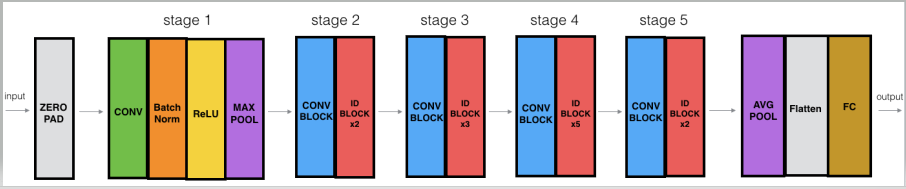
**Figure 5** </u><font color='purple'>  : **ResNet-50 model** </center></caption>
Các chi tiết của mô hình ResNet-50 này là:
- Zero-padding đệm đầu vào bằng pad (3,3)
- Giai đoạn 1:
    - 2D Convolution có 64 bộ lọc hình dạng (7,7) và sử dụng sải chân là (2,2). Tên của nó là "CONV1".
    - BatchNorm được áp dụng cho trục 'kênh' của đầu vào.
    - MaxPooling sử dụng một cửa sổ (3,3) và một (2,2) sải chân.
- Giai đoạn 2:
    - Khối chập sử dụng ba bộ lọc có kích thước là [64,64,256], "f" là 3, "s" là 1 và khối là "a".
    - 2 khối nhận dạng sử dụng ba bộ lọc có kích thước [64,64,256], "f" là 3 và các khối là "b" và "c".
- Giai đoạn 3:
    - Khối chập sử dụng ba bộ lọc có kích thước là [128,128,512], "f" là 3, "s" là 2 và khối là "a".
    - 3 khối định danh sử dụng ba bộ lọc có kích thước [128,128,512], "f" là 3 và các khối là "b", "c" và "d".
- Giai đoạn 4:
    - Khối chập sử dụng ba bộ lọc có kích thước là [256, 256, 1024], "f" là 3, "s" là 2 và khối là "a".
    - 5 khối định danh sử dụng ba bộ lọc có kích thước [256, 256, 1024], "f" là 3 và các khối là "b", "c", "d", "e" và "f".
- Giai đoạn 5:
    - Khối chập sử dụng ba bộ lọc có kích thước là [512, 512, 2048], "f" là 3, "s" là 2 và khối là "a".
    - 2 khối nhận dạng sử dụng ba bộ lọc có kích thước [512, 512, 2048], "f" là 3 và các khối là "b" và "c".
- Tổng số trung bình 2D sử dụng một cửa sổ có hình dạng (2,2) và tên của nó là "avg_pool".
- Lớp 'làm phẳng' không có bất kỳ siêu tham số hoặc tên nào.
- Lớp Kết nối đầy đủ (Dày đặc) giảm đầu vào của nó xuống số lớp bằng cách sử dụng kích hoạt softmax. Tên của nó phải là `` fc '+ str (các lớp)'.

**Bài tập**: Triển khai ResNet với 50 lớp được mô tả trong hình trên. Chúng tôi đã thực hiện Giai đoạn 1 và 2. Hãy thực hiện phần còn lại. (Cú pháp để thực hiện Giai đoạn 3-5 phải khá giống với Giai đoạn 2.) Đảm bảo bạn tuân theo quy ước đặt tên trong văn bản ở trên.

Bạn sẽ cần sử dụng chức năng này:
- Average pooling [see reference](https://keras.io/layers/pooling/#averagepooling2d)

Dưới đây là một số chức năng khác mà chúng tôi đã sử dụng trong đoạn mã dưới đây:
- Conv2D: [See reference](https://keras.io/layers/convolutional/#conv2d)
- BatchNorm: [See reference](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://keras.io/layers/convolutional/#zeropadding2d)
- Max pooling: [See reference](https://keras.io/layers/pooling/#maxpooling2d)
- Fully connected layer: [See reference](https://keras.io/layers/core/#dense)
- Addition: [See reference](https://keras.io/layers/merge/#add)

In [ ]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2))(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

Chạy đoạn mã sau để xây dựng đồ thị của mô hình. Nếu việc triển khai của bạn không đúng, bạn sẽ biết điều đó bằng cách kiểm tra độ chính xác của mình khi chạy `model.fit (...) 'bên dưới.

In [ ]:
model1 = ResNet50(input_shape = (64, 64, 3), classes = 6)

Như đã thấy trong Keras Tutorial Notebook, trước khi đào tạo một mô hình, bạn cần phải định cấu hình quá trình học bằng cách biên dịch mô hình.

In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Hãy tải Tập dữ liệu SIGNS.
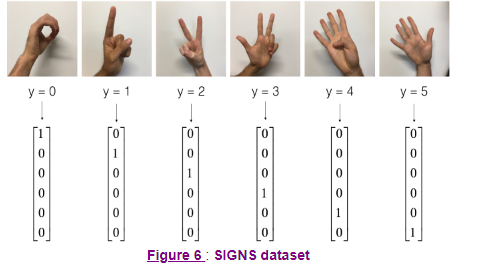

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [ ]:
model1.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
34/34 [==============================] - 9s 82ms/step - loss: 2.8663 - accuracy: 0.3410
Epoch 2/20
34/34 [==============================] - 2s 55ms/step - loss: 0.8610 - accuracy: 0.7618
Epoch 3/20
34/34 [==============================] - 2s 55ms/step - loss: 0.8066 - accuracy: 0.7709
Epoch 4/20
34/34 [==============================] - 2s 55ms/step - loss: 0.4861 - accuracy: 0.8348
Epoch 5/20
34/34 [==============================] - 2s 55ms/step - loss: 0.2776 - accuracy: 0.9059
Epoch 6/20
34/34 [==============================] - 2s 55ms/step - loss: 0.0865 - accuracy: 0.9758
Epoch 7/20
34/34 [==============================] - 2s 55ms/step - loss: 0.1093 - accuracy: 0.9685
Epoch 8/20
34/34 [==============================] - 2s 55ms/step - loss: 0.2333 - accuracy: 0.9307
Epoch 9/20
34/34 [==============================] - 2s 55ms/step - loss: 0.1153 - accuracy: 0.9702
Epoch 10/20
34/34 [==============================] - 2s 56ms/step - loss: 0.2168 - accuracy: 0.9404
Epoch 11/

In [ ]:
preds = model1.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 31ms/step - loss: 0.2123 - accuracy: 0.9167
Loss = 0.21225975453853607
Test Accuracy = 0.9166666865348816


Với mục đích của nhiệm vụ này, chúng tôi đã yêu cầu bạn đào tạo mô hình chỉ trong hai kỷ nguyên. Bạn có thể thấy rằng nó đạt được hiệu suất kém. Vui lòng tiếp tục và nộp bài tập của bạn; để kiểm tra tính đúng đắn, người chấm điểm trực tuyến cũng sẽ chỉ chạy mã của bạn cho một số lượng nhỏ kỷ nguyên.

Sau khi bạn hoàn thành phần chính thức (đã xếp loại) này của bài tập này, bạn cũng có thể tùy chọn đào tạo ResNet để lặp lại nhiều lần hơn, nếu bạn muốn. Chúng tôi nhận được hiệu suất tốt hơn rất nhiều khi đào tạo trong ~ 20 kỷ nguyên, nhưng điều này sẽ mất hơn một giờ khi đào tạo trên CPU.

Sử dụng GPU, chúng tôi đã đào tạo trọng số của mô hình ResNet50 của riêng mình trên tập dữ liệu SIGNS. Bạn có thể tải và chạy mô hình được đào tạo của chúng tôi trên bộ thử nghiệm trong các ô bên dưới. Có thể mất ≈1 phút để tải mô hình.

In [ ]:
model = load_model('/content/drive/MyDrive/ResNet50.h5') 

In [ ]:
preds = model.evaluate(X_test, Y_test)
preds1 = model.evaluate(X_train, Y_train)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))
print('train accuracy = ' +str(preds1[1]))

34/34 [==============================] - 1s 19ms/step - loss: 0.3063 - accuracy: 0.9056
Loss = 0.5301783680915833
Test Accuracy = 0.8666666746139526
train accuracy = 0.9055555462837219


ResNet50 là một mô hình mạnh mẽ để phân loại hình ảnh khi nó được đào tạo cho đủ số lần lặp lại. Chúng tôi hy vọng bạn có thể sử dụng những gì bạn đã học và áp dụng nó vào vấn đề phân loại của riêng bạn để thực hiện độ chính xác tối tân.

Chúc mừng bạn đã hoàn thành nhiệm vụ này! Bây giờ bạn đã triển khai một hệ thống phân loại hình ảnh hiện đại nhất!

## 4 - Test on your own image (Optional/Ungraded)

Nếu muốn, bạn cũng có thể tự tay mình chụp ảnh và xem đầu ra của mô hình. Để thực hiện việc này:
1. Nhấp vào "Tệp" ở thanh trên của sổ ghi chép này, sau đó nhấp vào "Mở" để truy cập Coursera Hub của bạn.
2. Thêm hình ảnh của bạn vào thư mục của Máy tính xách tay Jupyter này, trong thư mục "hình ảnh"
3. Viết tên hình ảnh của bạn vào mã sau
4. Chạy mã và kiểm tra xem thuật toán có đúng không!

Input image shape: (1, 64, 64, 3)
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[6.8373337e-02 4.7492344e-07 5.7315640e-04 7.8996128e-01 1.4068608e-01
  4.0572297e-04]]
Class: 3


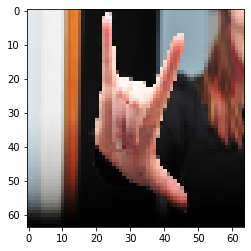

In [ ]:
img_path = '/content/20160630-023822-phs8n5r2io1_560x371.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))



Bạn cũng có thể in bản tóm tắt về mô hình của mình bằng cách chạy mã sau.

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

## Điều bạn nên nhớ
- Các mạng "plain" rất sâu không hoạt động trong thực tế vì chúng khó đào tạo do độ dốc biến mất.
- Các kết nối bỏ qua giúp giải quyết vấn đề Vanishing Gradient. Chúng cũng giúp một khối ResNet dễ dàng tìm hiểu một chức năng nhận dạng.
- Có hai loại khối chính: Khối định danh và khối chập.
- Mạng Thặng dư rất sâu được xây dựng bằng cách xếp chồng các khối này lại với nhau.
### References 

This notebook presents the ResNet algorithm due to He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py